# Background
This Dataset comes from https://www.insideairbnb.com
It is the most recent set as of this project, dated October 19, 2023.

I will be using this to learn about listings in Dallas. 
This will include information such as:
Where are listings concentrated, what listings compete with eachother, are hosts individual or multi-property managers, are hosts local or from out of town, and other information that we discover during analysis.

# Importing, understanding, and cleaning the data

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import directory
import folium
import math

In [63]:
#Read in Data
df_raw = pd.read_csv(directory.path + 'RawData/listings.csv')

In [64]:
pd.set_option('display.max_columns', None)
#df_raw.head()
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5596 entries, 0 to 5595
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            5596 non-null   int64  
 1   listing_url                                   5596 non-null   object 
 2   scrape_id                                     5596 non-null   int64  
 3   last_scraped                                  5596 non-null   object 
 4   source                                        5596 non-null   object 
 5   name                                          5596 non-null   object 
 6   description                                   5550 non-null   object 
 7   neighborhood_overview                         3286 non-null   object 
 8   picture_url                                   5596 non-null   object 
 9   host_id                                       5596 non-null   i

In [65]:
#Start data cleaning process.
#Drop unnecessary columns.
df = df_raw.loc[:,['id', 'name','host_id','host_since', 'host_location','host_acceptance_rate','host_is_superhost', 'host_neighbourhood', 'neighbourhood_cleansed','latitude','longitude', 'property_type', 'room_type', 'accommodates', 'bedrooms', 'beds', 'price','minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_communication', 'review_scores_location', 'review_scores_value']]

#Changes superhost true/false values to boolean values
#for i in range(len(df)):
#    if(df.loc[i,'host_is_superhost']=='f'):
#        df.loc[i,'host_is_superhost'] = False
#    elif(df.loc[i,'host_is_superhost']=='t'):
#        df.loc[i,'host_is_superhost'] = True
#df = df.reset_index(drop = True)

df['host_is_superhost'] = df['host_is_superhost'].replace({'t' : 1 , 'f' : 0})

#Change value of host_since to a date format
df['host_since'] = df['host_since'].astype('datetime64[ns]')

#Create new columns for price and acceptance rate. Changes the data type to a float value and removes the signs
df['price2'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['host_acceptance_rate2'] = df['host_acceptance_rate'].str.rstrip('%').astype('float') / 100.0

df.head()

,id,name,host_id,host_since,host_location,host_acceptance_rate,host_is_superhost,host_neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_communication,review_scores_location,review_scores_value,price2,host_acceptance_rate2
0,61878,Condo in Dallas · ★4.75 · 1 bedroom · 2 beds ·...,300211,2010-11-26,"Roanoke, TX",100%,0.0,Oak Lawn,District 2,32.81690,-96.82018,Entire condo,Entire home/apt,3,1.0,2.0,$85.00,30,1125,53,4.75,4.82,4.94,4.78,4.80,85.0,1.00
1,776810,Loft in Dallas · ★4.90 · 1 bedroom · 1 bed · 1...,4096626,2012-11-08,"Seattle, WA",0%,0.0,Oak Lawn,District 2,32.81462,-96.81586,Entire loft,Entire home/apt,2,1.0,1.0,$75.00,5,1125,29,4.90,4.89,4.96,5.00,4.78,75.0,0.00
2,795703,Condo in Dallas · ★4.84 · 1 bedroom · 1 bed · ...,4191322,2012-11-19,"Memphis, TN",100%,1.0,Oak Lawn,District 14,32.80327,-96.80976,Entire condo,Entire home/apt,2,1.0,1.0,$243.00,30,365,70,4.84,4.91,4.97,4.91,4.75,243.0,1.00
3,826118,Home in Dallas · ★4.83 · 1 bedroom · 1 bed · 1...,804559,2011-07-11,"Dallas, TX",69%,0.0,North Central Dallas,District 12,32.98825,-96.78926,Private room in home,Private room,2,NaN,1.0,$62.00,2,180,23,4.83,4.83,4.83,4.78,4.78,62.0,0.69
4,826201,Home in Dallas · ★4.77 · 1 bedroom · 1 bed · 1...,804559,2011-07-11,"Dallas, TX",69%,0.0,North Central Dallas,District 12,32.98853,-96.78903,Private room in home,Private room,2,NaN,1.0,$54.00,30,90,31,4.77,4.83,4.80,4.77,4.77,54.0,0.69


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5596 entries, 0 to 5595
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           5596 non-null   int64         
 1   name                         5596 non-null   object        
 2   host_id                      5596 non-null   int64         
 3   host_since                   5596 non-null   datetime64[ns]
 4   host_location                4228 non-null   object        
 5   host_acceptance_rate         5137 non-null   object        
 6   host_is_superhost            5441 non-null   float64       
 7   host_neighbourhood           5118 non-null   object        
 8   neighbourhood_cleansed       5596 non-null   object        
 9   latitude                     5596 non-null   float64       
 10  longitude                    5596 non-null   float64       
 11  property_type                5596 non-null 

In [67]:
#df.host_location.unique()
#Lots of locations! France, Dubai, Thailand, Dominican Republic, allegedly the DFW airport. Also hosts from all over the US!

In [68]:
#Number of Hosts (Unique Host IDs)
numHosts = df['host_id'].nunique()
print("There are",numHosts,"hosts with properties in Dallas")

#Number of Listings
numListings = len(df)
print("There are",numListings,"listings in Dallas")

#Descriptions of the Data
df[['accommodates','bedrooms','beds','price2','host_acceptance_rate2','number_of_reviews','review_scores_rating']].describe().round(2)

There are 2593 hosts with properties in Dallas
There are 5596 listings in Dallas


,accommodates,bedrooms,beds,price2,host_acceptance_rate2,number_of_reviews,review_scores_rating
count,5596.00,4766.00,5550.00,5596.00,5137.00,5596.00,4630.00
mean,4.95,2.01,2.55,209.77,0.93,36.47,4.72
std,3.42,1.32,2.05,642.15,0.17,73.46,0.49
min,1.00,1.00,1.00,10.00,0.00,0.00,0.00
25%,2.00,1.00,1.00,85.00,0.95,2.00,4.67
50%,4.00,2.00,2.00,120.00,0.99,10.00,4.85
75%,6.00,3.00,3.00,192.00,1.00,38.00,5.00
max,16.00,33.00,39.00,20256.00,1.00,1097.00,5.00


In [69]:
#Drop listings with less than 5 reviews
df.drop(df[df['number_of_reviews'] <= 5].index, inplace = True)

#Remove listings with a 0% Acceptance Rate
df.drop(df[df['host_acceptance_rate2'] == 0].index, inplace = True)

#Restrict listings with prices greater than $1000
#df.drop(df[df['price2'] >= 1000].index, inplace = True)

df = df.reset_index(drop = True)

df[['accommodates','bedrooms','beds','price2','host_acceptance_rate2','number_of_reviews','review_scores_rating']].describe().round(2)

,accommodates,bedrooms,beds,price2,host_acceptance_rate2,number_of_reviews,review_scores_rating
count,3386.00,2952.00,3368.00,3386.00,3228.00,3386.00,3386.00
mean,5.25,2.10,2.72,187.90,0.96,59.12,4.77
std,3.51,1.27,2.10,586.21,0.08,87.19,0.25
min,1.00,1.00,1.00,23.00,0.06,6.00,2.50
25%,2.00,1.00,1.00,85.00,0.96,13.00,4.69
50%,4.00,2.00,2.00,120.00,0.99,28.00,4.83
75%,6.00,3.00,4.00,190.00,1.00,68.00,4.94
max,16.00,12.00,22.00,20256.00,1.00,1097.00,5.00


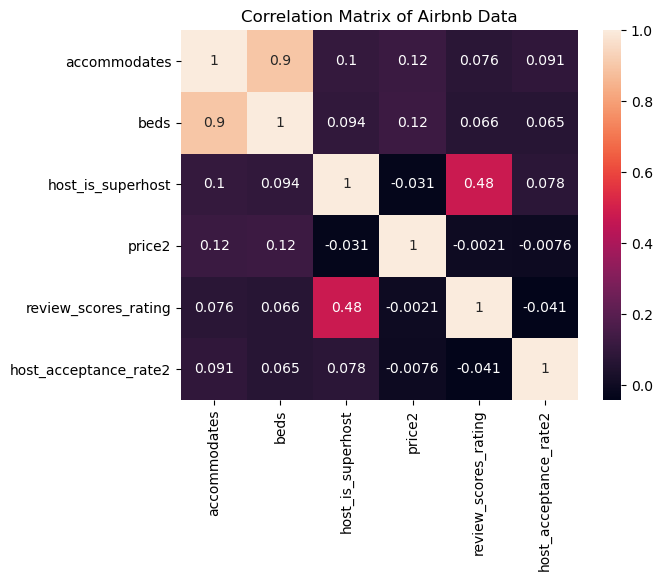

In [70]:
#Create a correlation matrix of features
#df.columns.unique()
df_Corr = df[['accommodates','beds','host_is_superhost','price2','review_scores_rating','host_acceptance_rate2']].copy()
#Neighbourhood Variables will need to be binned in order to gather correlation info
#df_Corr = df[['review_scores_rating','review_scores_accuracy','review_scores_communication','review_scores_location','review_scores_value','minimum_nights','maximum_nights']].copy()
#df_Corr.info()
#df_Corr
corr_matrix = df_Corr.corr()

sns.heatmap(corr_matrix, annot=True)

plt.title('Correlation Matrix of Airbnb Data')

plt.show()

A few interesting notes so far.

There is a listing for over $20k per night! Also, the median rating is a 4.77, which is not too far from perfect. Ratings are quite high!

Regarding correlations, there is almost no linear correlation between the price of an Airbnb, and the number of beds/people accommodated. In fact, there seem to be very few correlations at all. The correlation between prices and review scores is also almost 0. Correlations between superhost and price are almost 0, and superhost status shows little correlation with review ratings.

It is important to note, this data is not filtered very much yet.

In [71]:
#Restrict DF to properties of type "Entire home/apt"
df2 = df.copy()
df2.drop(df2[df2['room_type'] != "Entire home/apt"].index, inplace = True)

In [72]:
df3 = df2.copy()
df3.drop(df3[df3['property_type'] == "Entire guest suite"].index, inplace = True)
df3.drop(df3[df3['property_type'] == "Entire cottage"].index, inplace = True)
df3.drop(df3[df3['property_type'] == "Entire loft"].index, inplace = True)
df3.drop(df3[df3['property_type'] == "Campsite"].index, inplace = True)
df3.drop(df3[df3['property_type'] == "Entire cabin"].index, inplace = True)
df3.drop(df3[df3['property_type'] == "Entire villa"].index, inplace = True)
df3.drop(df3[df3['property_type'] == "Camper/RV"].index, inplace = True)
df3.drop(df3[df3['property_type'] == "Tiny house"].index, inplace = True)
df3.drop(df3[df3['property_type'] == "Boat"].index, inplace = True)
df3.drop(df3[df3['property_type'] == "Tent"].index, inplace = True)
df3.drop(df3[df3['property_type'] == "Bus"].index, inplace = True)
df3.drop(df3[df3['property_type'] == "Entire place"].index, inplace = True)
df3.drop(df3[df3['property_type'] == "Treehouse"].index, inplace = True)
df3.drop(df3[df3['property_type'] == "Yurt"].index, inplace = True)
df3.drop(df3[df3['property_type'] == "Houseboat"].index, inplace = True)
df3.drop(df3[df3['property_type'] == "Farm stay"].index, inplace = True)
df3.drop(df3[df3['property_type'] == "Barn"].index, inplace = True)
df3.drop(df3[df3['property_type'] == "Dome house"].index, inplace = True)
df3.drop(df3[df3['property_type'] == "Room in aparthotel"].index, inplace = True)
df3.drop(df3[df3['property_type'] == "Earth house"].index, inplace = True)

In [73]:
#Drop below 5th percentile and above 95th percentile
df3['price2'].describe(percentiles = [0.05, 0.95])
q5 = 69.25
q95 = 650
df3.drop(df3[df3['price2'] < q5].index, inplace = True)
df3.drop(df3[df3['price2'] > q95].index, inplace = True)
df3 = df3.reset_index(drop = True)

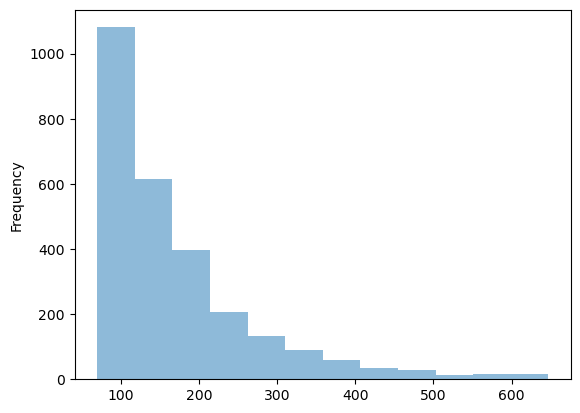

In [74]:
plot = df3['price2'].plot.hist(bins=12, alpha=0.5)

In [75]:
#Number of Hosts Remaining
numHosts2 = df3['host_id'].nunique()
print("There are",numHosts2,"hosts remaining")

#Number of Listings
numListings2 = len(df3)
print("There are",numListings2,"listings remaining")
df3[['accommodates','bedrooms','beds','price2','host_acceptance_rate2','number_of_reviews','review_scores_rating']].describe()

There are 1398 hosts remaining
There are 2694 listings remaining


,accommodates,bedrooms,beds,price2,host_acceptance_rate2,number_of_reviews,review_scores_rating
count,2694.000000,2630.000000,2681.000000,2694.000000,2604.000000,2694.000000,2694.000000
mean,5.824053,2.163878,2.987691,170.197476,0.968425,57.730883,4.762116
std,3.482629,1.245817,2.119789,102.748220,0.068789,81.428136,0.260403
min,1.000000,1.000000,1.000000,70.000000,0.060000,6.000000,2.500000
25%,3.000000,1.000000,1.000000,99.000000,0.970000,13.000000,4.680000
50%,5.000000,2.000000,2.000000,135.000000,0.990000,29.000000,4.830000
75%,8.000000,3.000000,4.000000,202.000000,1.000000,67.000000,4.930000
max,16.000000,8.000000,17.000000,647.000000,1.000000,1014.000000,5.000000


# 3. Plot the data

In [76]:
#Map centered on Downtown Dallas (coordinates 32.7791, -96.8003) with a `zoom_start` value of 11
f = folium.Figure(width=800, height=500)
m = folium.Map(location=[32.7791, -96.8003], zoom_start=11, tiles='CartoDB positron').add_to(f)

for point in range(0, len(df)):
    lat = df['latitude'][point]
    long = df['longitude'][point]
    temp = lat,long
    folium.CircleMarker(temp,radius=0.001).add_to(m)
m

# 4. Learning about hosts

Here, I will create a new dataframe for hosts. This will allow me to check if hosts that manage more than one listing charge a higher or lower price on average. This idea will also be used for superhost status.

In [77]:
df_hosts = df3.groupby(['host_id','host_is_superhost']).agg({'id': 'count','price2': 'mean'}).reset_index()
df_hosts.columns = ['host_id', 'isSuperhost', 'numListings','avgPrice']
df_hosts

,host_id,isSuperhost,numListings,avgPrice
0,43422,1.0,1,357.0
1,89845,0.0,1,125.0
2,104258,0.0,1,148.0
3,146477,1.0,1,95.0
4,182325,0.0,1,174.0
...,...,...,...,...
1355,530519220,0.0,1,125.0
1356,531520651,0.0,1,74.0
1357,531793163,0.0,1,85.0
1358,532405979,0.0,2,87.5


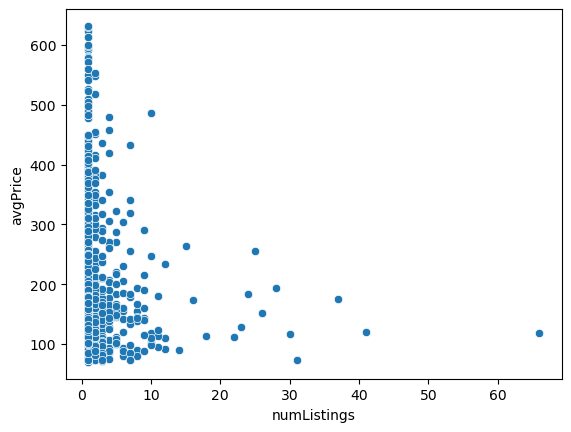

In [78]:
sns.scatterplot(data=df_hosts, x = 'numListings', y = 'avgPrice')
plt.show()

In [79]:
#Lets separate data on hosts with more than 20 listings. This will help us gather more insights on both groups
df5 = df_hosts.copy()
df_bigListingHosts = df_hosts.copy()
df5.drop(df5[df5['numListings'] >= 20].index, inplace = True)
df_bigListingHosts.drop(df_bigListingHosts[df_bigListingHosts['numListings'] < 20].index, inplace = True)